In [1]:
# PARAMS:
IN_FILENAME = '../data_src/btc_usd_24h_bitstamp.csv'
OUT_FILENAME = '../data_clean/btc_usd_24h_bitstamp.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
!lsb_release -a
!pwd
!python -V
!which python
# --- EXPECT:
# No LSB modules are available.
# Distributor ID:	Ubuntu
# Description:	Ubuntu 18.04.1 LTS
# Release:	18.04
# Codename:	bionic
# /data/learn/fucap/data_cleanup
# Python 2.7.15 :: Anaconda, Inc.
# /home/neuronq/miniconda3/envs/fucap/bin/python

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic
/data/learn/fucap/data_cleanup
Python 2.7.15 :: Anaconda, Inc.
/home/neuronq/miniconda3/envs/fucap/bin/python


In [3]:
# autoreload
%load_ext autoreload
%autoreload 1

# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import os
import sys
from datetime import datetime
import datetime as dtm
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

# add project dir to import path
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

%aimport lib.visualization
%aimport lib.helpers
from lib.visualization import simple_plot
import lib.helpers as helpers

### Sources
https://www.investing.com/crypto/bitcoin/btc-usd-historical-data?cid=49798
(Same data will be returned by Bitstamp API.)

In [5]:
def fill_missing(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['missing'] = 0

    from_dt = df.index.values[0]
    to_dt = df.index.values[-1]
    delta = np.timedelta64(1, 'D')
    dt = to_dt - delta
    
    empty = [np.nan] * len(df.columns)
    empty[-1] = 1

    while dt > from_dt:
        if dt not in df.index:
            df.loc[dt] = empty
        dt -= delta
    
    df.sort_index(inplace=True)
    
    df.fillna(method='ffill', inplace=True)
    
    return df

In [6]:
data = pd.read_csv(IN_FILENAME)
print('> size:', len(data))
dd(data.head())
dd(data.tail())

> size: 1351


,Date,Price,Open,High,Low,Vol.,Change %
0,"Oct 13, 2018","6,195.0","6,180.8","6,214.1","6,168.8",2.27K,0.16%
1,"Oct 12, 2018","6,184.9","6,152.8","6,238.3","6,109.8",3.25K,0.39%
2,"Oct 11, 2018","6,161.0","6,517.5","6,518.4","6,067.0",9.62K,-5.47%
3,"Oct 10, 2018","6,517.5","6,588.7","6,589.8","6,400.0",5.18K,-1.08%
4,"Oct 09, 2018","6,588.8","6,604.8","6,623.1","6,553.1",2.25K,-0.24%


,Date,Price,Open,High,Low,Vol.,Change %
1346,"Feb 05, 2015",217.0,227.0,228.9,213.6,4.31K,-4.41%
1347,"Feb 04, 2015",227.0,227.4,231.0,220.0,14.31K,-0.15%
1348,"Feb 03, 2015",227.4,238.0,244.4,223.8,17.76K,-4.46%
1349,"Feb 02, 2015",238.0,214.8,242.0,214.8,6.42K,10.79%
1350,"Feb 01, 2015",214.8,218.0,220.8,208.5,6.19K,-1.46%


In [7]:
data['datetime'] = pd.to_datetime(data['Date'])
data.set_index('datetime', inplace=True)
data.drop(['Date'], axis=1, inplace=True)
data.head(2)

,Price,Open,High,Low,Vol.,Change %
datetime,,,,,,
2018-10-13,"6,195.0","6,180.8","6,214.1","6,168.8",2.27K,0.16%
2018-10-12,"6,184.9","6,152.8","6,238.3","6,109.8",3.25K,0.39%


In [8]:
data.rename(str.lower, axis='columns', inplace=True)
data.rename({'price': 'close', 'vol.': 'volume'}, axis='columns', inplace=True)
data.drop(['change %'], axis=1, inplace=True)
data.head(2)

,close,open,high,low,volume
datetime,,,,,
2018-10-13,"6,195.0","6,180.8","6,214.1","6,168.8",2.27K
2018-10-12,"6,184.9","6,152.8","6,238.3","6,109.8",3.25K


In [9]:
data['volume'] = data['volume'].str.replace('K', '').replace('-', 'nan').astype(float)
dd(data.head(2))
data.dtypes

,close,open,high,low,volume
datetime,,,,,
2018-10-13,"6,195.0","6,180.8","6,214.1","6,168.8",2.27
2018-10-12,"6,184.9","6,152.8","6,238.3","6,109.8",3.25


close      object
open       object
high       object
low        object
volume    float64
dtype: object

In [10]:
data['close'] = data['close'].str.replace(',', '').astype(float)

In [11]:
data['open'] = data['open'].str.replace(',', '').astype(float)

In [12]:
data['high'] = data['high'].str.replace(',', '').astype(float)

In [13]:
data['low'] = data['low'].str.replace(',', '').astype(float)

In [14]:
data.dtypes

close     float64
open      float64
high      float64
low       float64
volume    float64
dtype: object

In [15]:
data.head(2)

,close,open,high,low,volume
datetime,,,,,
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25


In [17]:
fill_missing(data, inplace=True)
print('Missing:', int(data['missing'].sum()))
# EXPECT: Missing: 0

Missing: 0


In [22]:
dd(len(data))
dd(data.dtypes)
data.head()

1351

close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


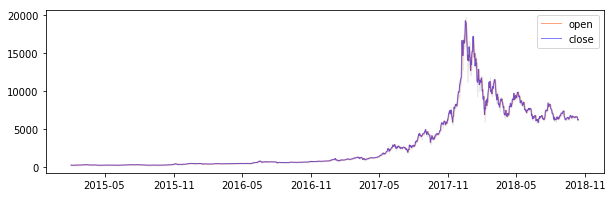

In [19]:
simple_plot(data, show_xlabels=False)

In [23]:
data.index

DatetimeIndex(['2015-02-01', '2015-02-02', '2015-02-03', '2015-02-04',
               '2015-02-05', '2015-02-06', '2015-02-07', '2015-02-08',
               '2015-02-09', '2015-02-10',
               ...
               '2018-10-04', '2018-10-05', '2018-10-06', '2018-10-07',
               '2018-10-08', '2018-10-09', '2018-10-10', '2018-10-11',
               '2018-10-12', '2018-10-13'],
              dtype='datetime64[ns]', name=u'datetime', length=1351, freq=None)

--- Last 6 M:


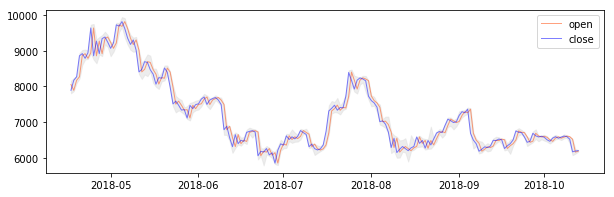

In [68]:
print('--- Last 6 M:')
simple_plot(
    data[datetime.today() - dtm.timedelta(days=6 * 30):],
    show_xlabels=False)

In [70]:
data.to_csv(OUT_FILENAME)